## Solving for Displacement

In this example we will extend the basis of Finite Element Method that was introduced in exercise 1 to solving more complex problems, such as solving for vector fields and apply different boundary conditions problems.

Finite Element Method is often used in solving engineering problems. For example calculating how materials and structures react when certain stresses are applied.

//// More introduction to the probelm/////
These concepts are fairly straight forward to extend to 3D, so we will focus on 2D for now

When first building a numerical simulation we want to test it on probelms with analytical solution to make sure there are no bugs in the code and it is working as expected. So first we will use cantilever in 2D problem

##### Cantilever beam in 2D

Imagine we have a beam of length L and height H that is attached to a wall on one side and there is a load applied to the beam on free hanging side. If the load is strong enough, the beam will bend. We can simulate the movement of the beam using Finite Element Method. 

We can solve for the displacement 

## Problem Set Up
### Step 1.Domain Set Up and Meshing
The domain set up and meshing does not depend on the type of solution variable we have. This only depends on the refinement of the domain and type of elements we have to use. However, it is generally good to review the ODE/PDE that is being solving to understand the degree of the differential equation, as this will guide the element degree. In this example we will use elements of degree two. The function below will create and mesh the domain using the inputs provided below in the same way as in first example.

(Note, add a note about how for displacement its good to use degree 2 +reference)

In [19]:
from FEM_Module.FEM_Module_class import FEM_model
# import meshio
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib.tri import Triangulation

First we set up the boundaries of the domain and specify the type and size of elements that we want to use. We can visualise this domain to understand the level of refinement that we have

In [20]:
########### The following inputs can be changed ################
## Domain Definition ##
x_start = 0
x_end = 60
y_start = -1.5
y_end = 1.5
domain_dim = 2


### Input Element Type 
element_degree = 2 # specify the element order
element_length =2 # specify the domain refinement. Finer meshes lead to more accurate solution


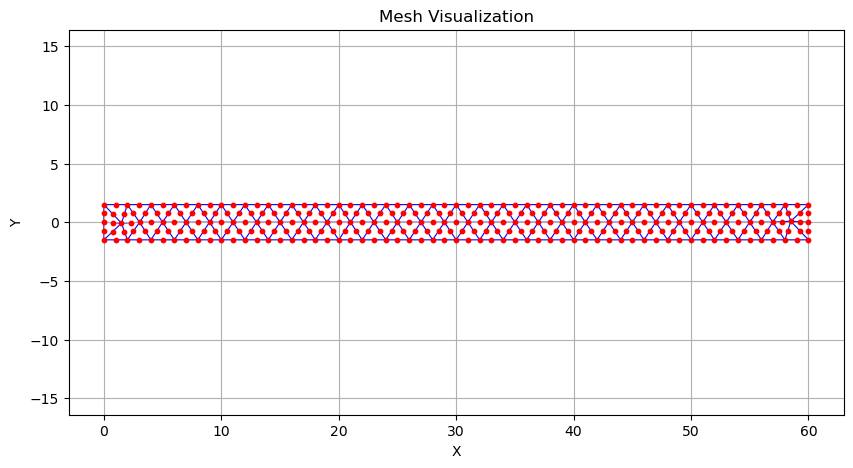

In [21]:
# Initialise the FEM model
FEM_ = FEM_model(domain_dim)

L=x_end- x_start
t=1
c=(y_end-y_start)/2.

## Create the domain name
FEM_.domain_mesh(element_degree, element_length, [x_start,x_end], [y_start,y_end])
FEM_.visualise_mesh()

As the load is applied to the beam of the left side along the line x = 0 and the beam moves. There is displacement associated with each node in two directions: x - direction and y-direction. Given the load is upward we expect the majority of the displacement to be in that direction, but some displacement in x-direction is expected too.

### Step 2. Properties Set Up and Analytical Solution
Next step is to define the material properties of the beam. The Young's modulus decribes how stiff the beam is, for stiffer materials we have to apply more load in order for the beam to bend. The Poisson ratio describes how much displacement there is in a material perpendicular to the direction of loading.

 We will also define the load applied to the end of the beam

In [22]:
## Set up material properties

Youngs_modulus = 1e6
Poisson_ratio = 0.25

## Load
P=80


Given there is an analytical solution for this problem, we can calculate the displacement in both directions at any point on the beam with coordinates (x,y). 
// ADD the analytical solution here: 


In [23]:
def analytical_solution_x(x, y, P, L, E, Poisson, c, t):
    """ Analytical solution in x -direction at point (x,y)

    Parameters
    -----------
    x,y (floats) : gloabl coordinates of the point
    P (float) : load applied at the end of the beam
    L (float) : length of the beam
    E (float) : Youngs modulus
    Poisson (float) : Poisson ratio of material
    c (float) : Half of the height of the beam
    t (float) :
    """
    I = (2 * t * c**3) / 3.
    G = E / (2 * (1 + Poisson))
    part0 = (P * (x**2 - L**2) * y) / (2 * E * I)
    part1 = (Poisson * P * y * (y**2 - c**2)) / (6 * E * I)
    part2 = (P * y * (y**2 - c**2)) / (6 * G * I)

    return -part0-part1+part2

def analytical_solution_y(x, y, P, L, E, Poisson, c, t):
    """ Analytical solution in y -direction at point (x,y)

    Parameters
    -----------
    x,y (floats) : gloabl coordinates of the point
    P (float) : load applied at the end of the beam
    L (float) : length of the beam
    E (float) : Youngs modulus
    Poisson (float) : Poisson ratio of material
    c (float) : Half of the height of the beam
    t (float) :
    """
    I = (2 * t * c * c**2) / 3
    G = E/(2*(1+Poisson))
    part0 = (Poisson * P * x * y**2) / (2 * E * I)
    part1 = (P * (x**3 - L**3)) / (6 * E * I)
    part2 = (P * L**2) / (2 * E * I)
    part3 = (Poisson * P * c**2) / (6 * E * I)
    part4 = (P * c**2) / (3 * G * I)

    return part0+part1-(part2+part3+part4)*(x-L)

### Step 3. Linear System Assembly

The main step in Finite Element Method is assemblying the linear system of equations that present the differential system that we want to solve. This step is very similar to the previous example apart from two key parts:


1) 
The size of our linear system will be different. For scalar fields there is only one degree of freedom per node. However, when we solve for vector fields, there are multiple degree of freedom per node, since each node can move in multiple dimensions. We have to account for that when we are setting up the system and adding the element contributions to the global matrix. In this way we have a choice of how to set up and the key is to be consistent for each element and the right hand side vector. We will choose the structure where the degree of freedoms per nodes are assigned to consecutive rows in order of x and y displacement respectively. This means that for node with global ID = 0, for two dimentional solution the x-displacement will be in index 0 in solution and the y-displacement will be in index 1, i.e. the solution vector will look like
$$\begin{bmatrix} x0 \\ y0 \\ x1 \\ y1 \\...\\ x_m \\ y_m \end{bmatrix}$$

where index is the global node ID. This will need to be accounted for during the accumulation of element level LHS matrix to the global matrix A.



2) 
The differential equation that we are solving is different so in the element accumulations we have to apply slightly different calculations. Instead of using the derivative of basis functions as is we have to transform them because we have to account for the strain - displacement relation. 

#### Exercise. Write accumulation loop

Given the physical equation 

$$\int_{\Omega} B^T_2DB_2 d\Omega,$$

where $B_2 = \overline{\nabla} \bf{N}$ , where $\overline{\nabla}$ is operator for two-dimensional displacement defined as 
\begin{equation}
\begin{bmatrix}
\frac{\partial}{\partial x} & 0\\[4pt]
0 & \frac{\partial}{\partial y}\\[4pt]
\frac{\partial}{\partial y} & \frac{\partial}{\partial x}\\[4pt]
\end{bmatrix}
\end{equation}

and $D$ is the stiffness matrix for the material...

Including the accumulation of local stiffness matrix LHS to global matrix A, accounting for the fact that there are two degrees of freedom per node.

In [24]:
## Set up empty matrix global matrix A and the right hand side vector b

num_nodes = len(FEM_.mesh.points)
A_matrix = np.zeros((num_nodes*domain_dim, num_nodes*domain_dim)) ## !!
b = np.zeros((num_nodes*domain_dim,))


## Now we iterate through each element in the mesh in the same way before
for element in FEM_.element_list_2D:
   
    # get the list of integration points and the list of global IDs for nodes in the element
    IntegrationPoints, IP_weights = FEM_.integrationPoints()
   
    e_nodes_xy = FEM_.global_node_coords[element][:,:3]

    ## we first get the element stiffness matrix for the element by accumulating
    ## over all the integration points. The element stiffness matrix also has to be adjusted 
    ## for multiple degree of  freedom
    
    LHS = np.zeros((len(element)*domain_dim, len(element)*domain_dim)) 
    
    ## Iterate over each integration point
    for IP, weight in zip(IntegrationPoints,IP_weights):
        continue
   ######************ Input code here  ********** ########

    for i in range(len(element)):
        for j in range(len(element)):
            col = int(element[i])
            row = int(element[j])
         
            ######************ Input code here  ********** ########

In [25]:
#### This is temp cell for develpment and will be the solution for the exercise
num_nodes = len(FEM_.mesh.points)
A_matrix = np.zeros((num_nodes*domain_dim, num_nodes*domain_dim)) ## !!
b = np.zeros((num_nodes*domain_dim,))


## Now we iterate through each element in the mesh in the same way before
for element in FEM_.element_list_2D:
   
    # get the list of integration points and the list of global IDs for nodes in the element
    IntegrationPoints, IP_weights = FEM_.integrationPoints()
   
    e_nodes_xy = FEM_.global_node_coords[element][:,:3]

    ## we first get the element stiffness matrix for the element by accumulating
    ## over all the integration points. The element stiffness matrix also has to be adjusted 
    ## for multiple degree of  freedom
    
    LHS = np.zeros((len(element)*domain_dim, len(element)*domain_dim)) 
    
    ## Iterate over each integration point
    for IP, weight in zip(IntegrationPoints,IP_weights):
        
        
        detJ, JMat = FEM_.Jacobian(IP, e_nodes_xy)
        B = FEM_.basis_functions_der(IP)
        B_JInv = np.matmul(np.linalg.inv(JMat), B)
        B_2 =  FEM_.dN_To2DOF(B_JInv)
        BT = B_2.transpose()
        D = FEM_.stiffness_matrix_2D(Youngs_modulus,Poisson_ratio)
        BT = np.matmul(BT, D)
        BT = np.matmul(BT, B_2)

        BT = BT * weight*(detJ) ## currently assume all the wieght of IP are the same
        LHS += BT

    for i in range(len(element)):
        for j in range(len(element)):
            col = int(element[i])
            row = int(element[j])
            A_matrix[row*domain_dim,col*domain_dim]+= LHS[int(j*domain_dim)][int(i*domain_dim)] # xx
            A_matrix[row*domain_dim,col*domain_dim+1]+= LHS[int(j*domain_dim)][int(i*domain_dim+1)] # xy
            A_matrix[row*domain_dim+1,col*domain_dim]+= LHS[int(j*domain_dim+1)][int(i*domain_dim)] # y
            A_matrix[row*domain_dim+1,col*domain_dim+1]+= LHS[int(j*domain_dim+1)][int(i*domain_dim+1)] # y


<details>
<summary>Solution</summary>
    sample code
    ```
num_nodes = len(FEM_.mesh.points)
A_matrix = np.zeros((num_nodes*domain_dim, num_nodes*domain_dim)) ## !!
b = np.zeros((num_nodes*domain_dim,))


## Now we iterate through each element in the mesh in the same way before
for element in FEM_.element_list_2D:
   
    # get the list of integration points and the list of global IDs for nodes in the element
    IntegrationPoints, IP_weights = FEM_.integrationPoints()
   
    e_nodes_xy = FEM_.global_node_coords[element][:,:3]

    ## we first get the element stiffness matrix for the element by accumulating
    ## over all the integration points. The element stiffness matrix also has to be adjusted 
    ## for multiple degree of  freedom
    
    LHS = np.zeros((len(element)*domain_dim, len(element)*domain_dim)) 
    
    ## Iterate over each integration point
    for IP, weight in zip(IntegrationPoints,IP_weights):
        
        
        detJ, JMat = FEM_.Jacobian(IP, e_nodes_xy)
        B = FEM_.basis_functions_der(IP)
        B_JInv = np.matmul(np.linalg.inv(JMat), B)
        B_2 =  FEM_.dN_To2DOF(B_JInv)
        BT = B_2.transpose()
        D = FEM_.stiffness_matrix_2D(Youngs_modulus,Poisson_ratio)
        BT = np.matmul(BT, D)
        BT = np.matmul(BT, B_2)

        BT = BT * weight*(detJ) ## currently assume all the wieght of IP are the same
        LHS += BT

    for i in range(len(element)):
        for j in range(len(element)):
            col = int(element[i])
            row = int(element[j])
            A_matrix[row*domain_dim,col*domain_dim]+= LHS[int(j*domain_dim)][int(i*domain_dim)] # xx
            A_matrix[row*domain_dim,col*domain_dim+1]+= LHS[int(j*domain_dim)][int(i*domain_dim+1)] # xy
            A_matrix[row*domain_dim+1,col*domain_dim]+= LHS[int(j*domain_dim+1)][int(i*domain_dim)] # y
            A_matrix[row*domain_dim+1,col*domain_dim+1]+= LHS[int(j*domain_dim+1)][int(i*domain_dim+1)] # y

    ```
</details>

## Apply Boundary Conditions

There are several types of boundary conditions that exist for differential equations. In previous notebook we applied Dirichlet boudnary conditions, where we know the value of a solution at a specific points. Therefore we are able to set the solution nodes at those points to that value. 

Another type of boundary condition that is generally applies in Neumann boundary condition. For this boundary condition we know the value of the derivative of the solution at specific points. For example, applying a load or force to domain as we have in this example is a case of Neumann boundary condition. In thes cases we don't know what the solution value is at the boudary, we only know how it behaves with respect to its adjacent nodes. Therefore, we can't set the right hand side vector to a specific value as we have done before and another method is required. 

Noting that in FEM when we accumulate the left hand side matrix, we aim to replicate the bahaviour of the differential equation on an element by element basis, then to replciate the behaviour of derivative at a boundary we need to do the same with the right hand side vector. 

We follow similar process of accumulation for every element at the boundary but we add it to the RHS vector $b$ instead of the matrix $A$.

In our example we have a combination of boundary conitions, on the left is the Neumann BC due to the force being applied and on the right is the Dirichlet BC due to the cantilever being fixed to the wall and it cannot move.

#### Exercise. Accumulate the Neumann Boundary condiions

In our case the force is applied to the left side of the domain along the line x=0. Therefore we need to accumulate over line elements that exists along the boundaries and we need the basis functions and their derivatives for 1D elements. 

In [28]:
def basis_fun_line_quad(point):
    r = point
    N=np.zeros((3,))
    N[0] = 0.5*(r*r -r)
    N[1] = 0.5*(r*r +r)
    N[2] = 1-r*r
    return N

def der_basis_fun_line_quad(point):
    r = point
    dN=np.zeros((3,))
    dN[0] = r-0.5
    dN[1] = r+0.5
    dN[2] = -2*r
    return dN

def NeumannStress_value(P):
    return np.array([[P, 0.], 
                     [0., 0]])

def Jacobian_1D(pt, element_xy_coord):
    dN = der_basis_fun_line_quad(pt)
    x_vals=element_xy_coord[:,1]
    print(dN, x_vals)
    return np.dot(dN,x_vals )
   

In [29]:
### Identify the 1D eleemnts that lie on the left hand side boundary: 
left_ = np.where(np.isclose(FEM_.mesh.points[:,0], x_start))[0]

result = np.all(np.isin(FEM_.mesh.cells_dict['line3'], left_), axis=1)
indices = np.where(result)[0]
left_bc=FEM_.mesh.cells_dict['line3'][indices]
left_bc
# for i in FEM_.mesh.cells_dict['line3']

array([[  3, 125, 126],
       [125,   0, 127]], dtype=uint64)

explain here the concept of force being applied along a direction variable and that defines the NeumassStess_value matrix and how we accumulate to a vector and not a matrix

In [30]:
## Apply the Neumann BOundary Condition to the rhs vector on the LEFT
print(left_, FEM_.mesh.points[left_])

## 1D integrastion points
IP_line = [-np.sqrt(3./5.), 0., np.sqrt(3./5.)]
IP_w = [5/9.,8./9.,5./9.]


for element in left_bc: # for each line element in left boundary
    local_RHS=np.zeros((len(element)*2,1)) ## because 3 nodes but for 2 dim vector there are 2 d.o.f for each node
    element_xy_coord = FEM_.mesh.points[element]
    for IP, weights in zip(IP_line,IP_w):

        N = basis_fun_line_quad(IP)
        Nnc = np.zeros((3*2,1)) ## 3 nodes * 2 dim ( i think)
        detJ = Jacobian_1D(IP, element_xy_coord)
        Neumann_matrix = NeumannStress_value(P)
        for j in range(3):
            for df in range(2):  # for every dimension
                Nnc[j * 2 + df] += N[j] * weights * (detJ) * Neumann_matrix[df,df]

        local_RHS+=Nnc
    for i in range(len(element)):
        node = left_[i]
        b[node*2] += local_RHS[i*2]
        b[node*2+1] += local_RHS[(i*2)+1]


[  0   3 125 126 127] [[ 0.00000000e+00 -1.50000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.50000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.51136914e-12  0.00000000e+00]
 [ 0.00000000e+00  7.50000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -7.50000000e-01  0.00000000e+00]]
[-1.27459667 -0.27459667  1.54919334] [1.50000000e+00 5.51136914e-12 7.50000000e-01]
[-0.5  0.5 -0. ] [1.50000000e+00 5.51136914e-12 7.50000000e-01]
[ 0.27459667  1.27459667 -1.54919334] [1.50000000e+00 5.51136914e-12 7.50000000e-01]
[-1.27459667 -0.27459667  1.54919334] [ 5.51136914e-12 -1.50000000e+00 -7.50000000e-01]
[-0.5  0.5 -0. ] [ 5.51136914e-12 -1.50000000e+00 -7.50000000e-01]
[ 0.27459667  1.27459667 -1.54919334] [ 5.51136914e-12 -1.50000000e+00 -7.50000000e-01]


In [40]:
## Apply the Dirichlet BC
## Fix RIGHT sidde
right_ = np.where(np.isclose(FEM_.mesh.points[:,0],x_end))[0]
print(right_)
for node in right_:
    x_val = FEM_.mesh.points[node][0]
    y_val = FEM_.mesh.points[node][1]
    print(FEM_.mesh.points[node], x_val, y_val)
    
    ## x axis
    A_matrix[node*2,:] = 0
    A_matrix[node*2, node*2] = 1
    b[node*2 ] = analytical_solution_x(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t)
    print(analytical_solution_x(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t))
    
    #y axis
    A_matrix[node*2+1,:] = 0
    A_matrix[node*2+1, node*2+1] = 1
    b[node*2+1 ] = analytical_solution_y(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t)
    print( analytical_solution_y(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t))
    
    

[ 1  2 63 64 65]
[60.  -1.5  0. ] 60.0 -1.5
0.0
0.0006
[60.   1.5  0. ] 60.0 1.5
0.0
0.0006
[ 6.00000000e+01 -5.51136914e-12  0.00000000e+00] 60.0 -5.511369138844202e-12
1.6534107416532607e-16
8.100050609227808e-27
[60.   -0.75  0.  ] 60.0 -0.7500000000023812
1.687500000001786e-05
0.00015000000000095249
[60.    0.75  0.  ] 60.0 0.7499999999973297
-1.6874999999979973e-05
0.00014999999999893189


In [37]:
for i in b:
    if i != 0.0:
        print(i)

-40.00000000002453
0.0006
0.0006
-39.999999999975486
1.6534107416532607e-16
8.100050609227808e-27
1.687500000001786e-05
0.00015000000000095249
-1.6874999999979973e-05
0.00014999999999893189
-160.0


## Solve and Evaluate the Solution

In [34]:
## solve the linear systme of equations
x = np.linalg.solve(A_matrix, b)
x

array([-2.33768793e-03,  3.39962348e-03, -2.59460697e-13,  6.00000000e-04,
        4.17889832e-13,  6.00000000e-04, -2.17171621e-03,  3.36171081e-03,
       -2.25370644e-03,  3.28927757e-03, -2.17964238e-03,  3.18146211e-03,
       -2.10464060e-03,  3.07278060e-03, -2.02963482e-03,  2.96415650e-03,
       -1.95463507e-03,  2.85553417e-03, -1.87963509e-03,  2.74691138e-03,
       -1.80463509e-03,  2.63828859e-03, -1.72963509e-03,  2.52966581e-03,
       -1.65463509e-03,  2.42104303e-03, -1.57963509e-03,  2.31242024e-03,
       -1.50463509e-03,  2.20379746e-03, -1.42963509e-03,  2.09517468e-03,
       -1.35463509e-03,  1.98655189e-03, -1.27963509e-03,  1.87792911e-03,
       -1.20463509e-03,  1.76930632e-03, -1.12963509e-03,  1.66068354e-03,
       -1.05463509e-03,  1.55206076e-03, -9.79635089e-04,  1.44343797e-03,
       -9.04635089e-04,  1.33481519e-03, -8.29635089e-04,  1.22619241e-03,
       -7.54635089e-04,  1.11756962e-03, -6.79635089e-04,  1.00894684e-03,
       -6.04635089e-04,  

In [35]:
analytica_x_list =np.empty((0,2))
FEM_x =np.empty((0,2))


analytica_y_list =np.empty((0,2))
FEM_y =np.empty((0,2))
### Check along the top boundary

top_ = np.where(np.isclose(FEM_.mesh.points[:,1],y_end))[0]
for node in top_:
    x_val = round(FEM_.mesh.points[node][0],5)
    y_val = round(FEM_.mesh.points[node][1],5)
#     print(x_val, y_val)
    
    ## x -axis
    FEM_solution_x = x[node*2]
    analytical_x = analytical_solution_x(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t)
    
    # y axis
    FEM_solution_y = x[node*2+1]
    analytical_y = analytical_solution_y(x_val,y_val,P,L,Youngs_modulus,Poisson_ratio,c,t)
    
    analytica_x_list=np.append(analytica_x_list,[[x_val,analytical_x]], axis = 0)
    analytica_y_list=np.append(analytica_y_list,[[x_val,analytical_y]], axis = 0)
    
    FEM_x=np.append(FEM_x,[[x_val,FEM_solution_x]], axis=0)
    FEM_y=np.append(FEM_y,[[x_val,FEM_solution_y]], axis=0)

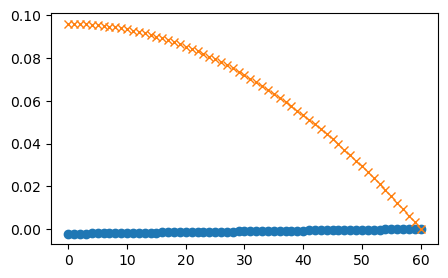

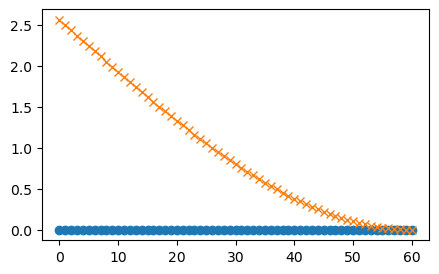

In [36]:
plt.figure(figsize=(5,3)) 
plt.plot(FEM_x[:,0],FEM_x[:,1], "o")
plt.plot(analytica_x_list[:,0],analytica_x_list[:,1], "x")
plt.figure(figsize=(5,3)) 
plt.plot(FEM_y[:,0],FEM_y[:,1], "o")
plt.plot(analytica_y_list[:,0],analytica_y_list[:,1], "x")